In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [56]:
"""
ЗАДАЧА 1
"""
class LinearRegressorGD:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.coefs = np.array([0.0])
        self.bias = 0.0
        
        # параметры для регуляризации
        self.penalty = "l2"
        self.alpha = 0.001
        pass

    """
    Можно Добавить еще и регуляризацию
    """
    def get_penalty_grad(self):
        if self.penalty == "l2":
            return np.sum(self.coefs * self.alpha) * 2
        elif self.penalty == "l1":
            return np.sign(self.coefs) * self.alpha
    

    def fit(self, X, y):
        samples = X.shape[0]
        coef_old = np.mean(X, axis=0).reshape(-1, 1)
        self.coefs = np.mean(X, axis=0).reshape(-1, 1)
        iter = 0
        while iter < self.n_iter:
            iter += 1
            Q_MSE = self.predict(X) - y
            grad_coefs = (1 / samples) * np.dot(X.T, Q_MSE) #+ self.get_penalty_grad()
            grad_bias = (1 / samples) * np.sum(Q_MSE) 
            
            self.coefs -= self.learning_rate * grad_coefs
            self.bias -= self.learning_rate * grad_bias
        pass
    
    def predict(self, X):
        return np.dot(X, self.coefs) + self.bias
        pass

    def get_params(self):
        return self.coefs, self.bias
        pass
    

In [57]:
"""
Задача 2
"""
class MLPRegressor:
    def __init__(self, hidden_layer_sizes=(100,), learning_rate=0.001, n_iter=1000):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.layers = []
        self.X_mean = None
        self.X_std = None
        self.y_mean = None
        self.y_std = None
        
    def build_layers(self, input_size):
        
        for layer in range(len(self.hidden_layer_sizes)):
            if(layer == 0):
                self.layers.append(Layer(self.hidden_layer_sizes[0], input_size))
            else:
                self.layers.append(Layer(self.hidden_layer_sizes[layer], self.hidden_layer_sizes[layer-1]))
                
        self.layers.append(Layer(1, self.hidden_layer_sizes[-1]))

        

    def forward(self, X):
        if (self.layers == []):
            self.build_layers(X.shape[1])
        
        output = X
        for i, layer in enumerate(self.layers):
            if(i < len(self.layers) - 1):
                activation_type = 1
                output = layer.forward(output, activation_type)
            else:
                activation_type = 0
                output = layer.forward(output, activation_type)

        return output
        pass

    def backward(self, X, y):

        predict = self.forward(X)
        
        Q_MSE = y.reshape(-1, 1) - predict
        self.layers[-1].error = Q_MSE
        self.layers[-1].delta = Q_MSE * 1.0  
        
        for i in reversed(range(len(self.layers) - 1)):
            layer = self.layers[i]
            next_layer = self.layers[i + 1]
            
            layer.error = np.dot(next_layer.delta, np.array([neuron.W[:-1] for neuron in next_layer.neurons]))
            layer.delta = layer.error * np.array([neuron.sigmoid_derivative() for neuron in layer.neurons]).T
        
        for i, layer in enumerate(self.layers):
            if i == 0:
                inputs = X
            else:
                inputs = self.layers[i-1].output
            
            for j, neuron in enumerate(layer.neurons):
                grad_w = np.dot(layer.delta[:, j], inputs)
                grad_b = np.sum(layer.delta[:, j])
                
                """
                Возможно в реализации есть ошибки, но без обрезки градиаента 
                градиент улетают куда-то далеко-далеко
                Возможно есть решение изящнее
                """
                max_grad_norm = 1.0
                grad_norm = np.sqrt(np.sum(grad_w**2) + grad_b**2)
                if grad_norm > max_grad_norm:
                    scale = max_grad_norm / (grad_norm + 1e-10)
                    grad_w *= scale
                    grad_b *= scale

                
                neuron.W[:-1] += self.learning_rate * grad_w
                neuron.W[-1] += self.learning_rate * grad_b
        pass
                
    """
    Опытным путем установлено, что без нормализации обучение расходится
    В беседе, что-то писали про норму в весах, но мне кажется легче нормализовать входные данные
    """
    def normalize_data(self, X, y):
        
        self.X_mean = np.mean(X, axis=0)
        self.X_std = np.std(X, axis=0)
        
        self.y_mean = np.mean(y)
        self.y_std = np.std(y)
        
        X_norm = (X - self.X_mean) / self.X_std
        y_norm = (y - self.y_mean) / self.y_std
        
        return X_norm, y_norm


    def fit(self, X, y):
        X_norm, y_norm = self.normalize_data(X, y)
        if not self.layers:
            self.build_layers(X.shape[1])
        for iter in range(self.n_iter):
            self.backward(X_norm, y_norm)

        pass
                


    def predict(self, X):
        
        X = np.array(X, dtype=np.float64)
        X_norm = (X - self.X_mean) / self.X_std
        predict_norm = self.forward(X_norm)
        return predict_norm * self.y_std + self.y_mean
        
        pass

class Layer:
    def __init__(self, num_neurons, input_size):
        self.input_size = input_size
        self.num_neurons = num_neurons
        self.output = None
        self.error = None
        self.delta = None
        self.neurons = [Neuron(input_size) for _ in range(num_neurons)]

    def forward(self, X, activation_type):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.activate(X, activation_type))
        self.output = np.array(outputs).T
        return self.output

class Neuron:
    def __init__(self, input_size):
        self.input_size = input_size
        self.W = np.random.randn(self.input_size + 1) * 0.1
        self.output = None

    def activate(self, X, activation_type):
        z = np.dot(X, self.W[:-1]) + self.W[-1]
        
        if activation_type:  
            self.output = 1 / (1 + np.exp(-z))
        else:  
            self.output = z
            
        return self.output

    def sigmoid_derivative(self):
        return self.output * (1 - self.output)

    def linear_derivative(self):
        return 1

In [58]:
diamonds_df = pd.read_csv('diamonds.csv')
diamonds_df.head()
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))
X = diamonds_df[features].copy().values
y = diamonds_df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
reg = LinearRegression().fit(X_train, y_train)

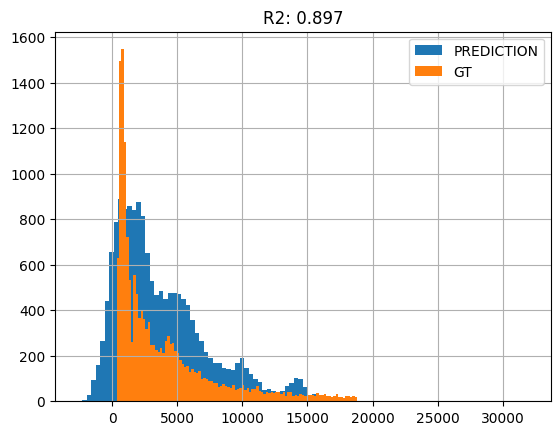

In [60]:
y_pred = reg.predict(X_test)
score = r2_score(y_pred, y_test)
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

In [61]:
"""
ЛИНЕЙНАЯ РЕГРЕССИЯ ТЕСТ
"""

'\nЛИНЕЙНАЯ РЕГРЕССИЯ ТЕСТ\n'

In [62]:
regGD = LinearRegressorGD(learning_rate = 0.5, n_iter=1000)
regGD.fit(X_train, y_train)

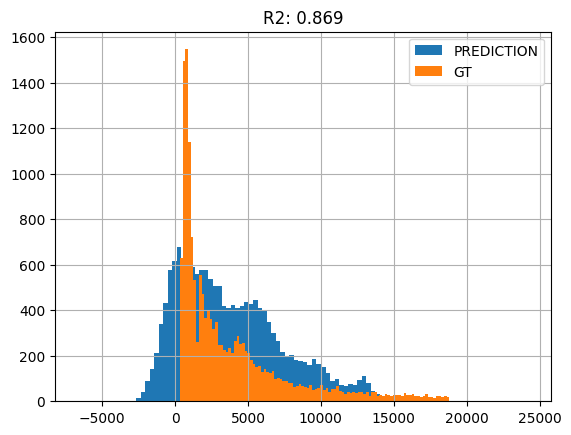

In [63]:
y_pred = regGD.predict(X_test)
score = r2_score(y_pred, y_test)
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

In [ ]:
"""
MLP ТЕСТ
"""

In [35]:
REG = MLPRegressor(hidden_layer_sizes=(50, 10), learning_rate = 0.1)

In [36]:
REG.fit(X_train, y_train)

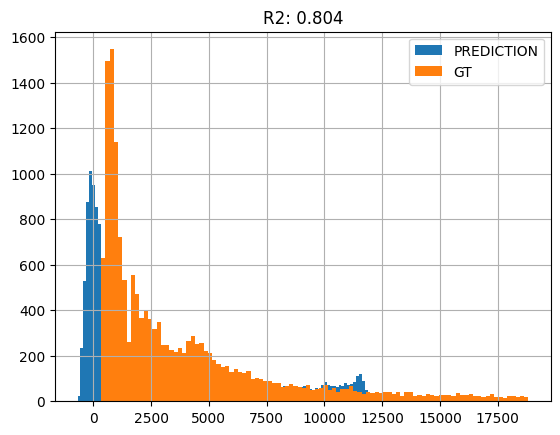

In [37]:
y_pred = REG.predict(X_test)
score = r2_score(y_pred, y_test)
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();